<H3>Homework 1 for Machine Learning course: Detection of Malwares</H1>

In [38]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [39]:
#Print of the dataset after it has been put in an array
def print_examples(data, x,y): #x,y num of rows and columns to be printed
  for j in range(x):
    for i in range(y):
      print('X[{},{}]= {}'.format(j,i, data[j,i]), end= ' ')
    print('\n')

In [40]:
#Print and plot consudion matrix. Normalization can be applied by setting `normalize=True
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
   
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.savefig('confusion_matrix.png')
    return ax

In [41]:
#X[i,:] ->  id, semantic, length, compare, bitwise, if, call, for, shift, arithmetic
#Semantic: encryption = 0, string = 1, sorting = 2, math = 3

def encoding(string): #Encoding of the possible classes
  if string == 'encryption': 
    return 0
  if string == 'string': 
    return 1
  if string == 'sort': 
    return 2
  if string == 'math': 
    return 3

def find_in_asm(asm): #Returns number of occurencies for each feature 
  length = asm.count("',") + 1
  #print(X[i,2])
  compare = asm.count("cmp") + asm.count("test")  
  xmm = asm.count("xmm") 
  bitwise = asm.count("xor") + asm.count("or") + asm.count("and")
  if_count = 0
  for s in ['je','jz','jne','js','jns','jg','jge','jl','ja','jle','jae','jb','jbe']:
    if_count += asm.count(s)
  call = asm.count("call") + asm.count("leave")
  for_count = asm.count("jmp")
  shift = asm.count("sar") + asm.count("shl") + asm.count("shr")
  arithmetic = asm.count("div") + asm.count("imul") + asm.count("inc") + asm.count("dec") + asm.count("neg") 
  move = asm.count("mov") + asm.count("lea")
  return length, compare, xmm, bitwise, if_count, call, for_count, shift, arithmetic, move

#Returns np-array X for dataset with features
def take_features(data, mode = 'train'): #mode == train for training phase, mode == blind for blind test
  data_len = len(data.readlines())
  print('Length of data: {}'.format(data_len))
  data.seek(0) #Go at the beginning of the file
  if mode == 'train':
    X = np.ndarray((data_len,12))
  else:
    X = np.ndarray((data_len,10))
  for i in range(0,data_len):
    json_data = json.loads(data.readline())
    #print(json_data)
    for key in json_data:
      if key == 'id' and mode=='train':
        X[i,0] = float(json_data[key])
        #print(X[i,0])
      if key == 'semantic' and mode=='train':
        X[i,1] = encoding(json_data[key])
        #print(X[i,1])
      if key == 'lista_asm' and mode=='train':
        X[i,2], X[i,3],X[i,4], X[i,5], X[i,6],X[i,7], X[i,8], X[i,9], X[i,10], X[i,11] = find_in_asm(json_data[key])
      elif key == 'lista_asm' and mode=='blind':
        X[i,0], X[i,1],X[i,2], X[i,3], X[i,4],X[i,5], X[i,6], X[i,7], X[i,8], X[i,9] = find_in_asm(json_data[key])
    '''for elem in range (0,11):
      if i%1000 == 0:
        print('X[{},{}]= {}'.format(i, elem, X[i,elem]), end= ' ')
        print()'''
  return X.astype(int)

In [42]:
#Split data
def split_dataset(data):
  labels = data[:,1] #Labels are in second coloumn -> semantic
  data_new = np.copy(data)
  data_new = np.delete(data_new, 1, 1) #Remove labels from data
  data_new = np.delete(data_new, 0, 1)
  '''print("Old format of dataset:\n")
  print_examples(data,10,12)
  print("----------------------------------------------")
  print("New format of dataset:\n")
  print_examples(data_new,10,10)
  print("----------------------------------------------")'''
  train_set, test_set, labels_train, labels_test = model_selection.train_test_split(data_new, labels,stratify = labels)#test_size=0.3, random_state=42)
  #stratify divides dataset in such a way that train and test sets contain equal percentage of each class -> better than test_size and random_state 
  '''print("Training set samples:\n")
  print_examples(train_set,10,10)
  print("----------------------------------------------")
  print("Test set samples:\n")
  print_examples(test_set,10,10)'''
  print('train_set len: {}, test_set len: {}'.format(len(train_set), len(test_set)))
  return train_set, test_set, labels_train, labels_test

In [43]:
#Scores
def display_scores(scores):
  print("----------------------------------------------")
  print("Acc {}".format(scores))
  print("Mean {}".format(scores.mean()))
  print("Standard deviation {}".format(scores.std()))
  print("----------------------------------------------")

<h1>MAIN</h1>

In [44]:
#Main
#Importing dataset
path = "/content/drive/My Drive/Machine Learning/HW1/noduplicatedataset.json"
file = open(path, 'r', encoding='utf-8')

#Take features
data = take_features(file)
file.close()

Length of data: 6073


In [45]:
#Split 
train_set, test_set, labels_train, labels_test = split_dataset(data)

train_set len: 4554, test_set len: 1519


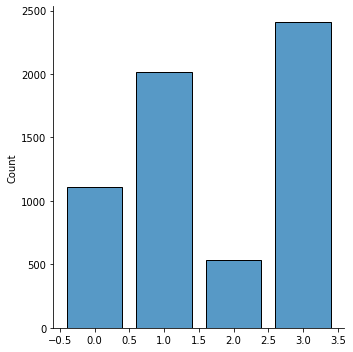

In [46]:
#Visualize dataset
sns_plot = sns.displot(data, x=data[:,1],discrete =True,shrink=0.8) #number of elements per class
#sns_plot.savefig("duplicates.png")

<h5>SMOTE to balance dataset</h5>

In [ ]:
#Install imbalance-learn library
#Sometimes it is needed to restart the runtime
#!pip install -U imbalanced-learn

In [ ]:
#This cell uses smote to modify dataset
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

labels = data[:,1] #Labels are in second coloumn -> semantic
data_new = np.copy(data)
data_new = np.delete(data_new, 1, 1) #Remove labels from data
data_new = np.delete(data_new, 0, 1)

#oversample = RandomOverSampler(sampling_strategy='minority')
#undersample = RandomUnderSampler(sampling_strategy='not minority')
oversample = BorderlineSMOTE()
X_over, y_over = oversample.fit_resample(data_new, labels)

print(Counter(y_over))

train_set, test_set, labels_train, labels_test = model_selection.train_test_split(data_new, labels,stratify = labels)

Counter({1: 2412, 3: 2412, 0: 2412, 2: 2412})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

<h1>Training phase</h1>

In [ ]:
#Decision Tree
tree_clf = DecisionTreeClassifier(criterion='entropy', class_weight='balanced')
scores = tree_clf.fit(train_set, labels_train)
scores = cross_val_score(tree_clf, train_set, labels_train, cv=10, scoring ="accuracy") #cv standard is 5
tree_rmse_scores = np.sqrt(scores)
display_scores(tree_rmse_scores)
y_pred = tree_clf.predict(test_set)

----------------------------------------------
Acc [0.97332853 0.98006444 0.98452945 0.97670229 0.98337834 0.98002018
 0.98114085 0.977775   0.97665048 0.98561076]
Mean 0.9799200333199529
Standard deviation 0.003690600059466077
----------------------------------------------


In [51]:
#Random Forest
forest = RandomForestClassifier(n_estimators=100, criterion='entropy', n_jobs=-1) #parameter n_jobs parallelizes over the trees -> with -1 uses all processors
forest.fit(train_set, labels_train)
scores = cross_val_score(forest, train_set, labels_train, cv=10, scoring ="accuracy") #cv standanrd is 5
forest_rmse_scores = np.sqrt(scores)
display_scores(forest_rmse_scores)
y_pred = forest.predict(test_set)

----------------------------------------------
Acc [0.9889743  0.98229949 0.97894501 0.9811826  0.98783813 0.98894994
 0.98783813 0.98449518 0.98783813 0.98337834]
Mean 0.9851739266284609
Standard deviation 0.003415734066633181
----------------------------------------------


In [ ]:
#SVM
svm_clf = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
score_svm = svm_clf.fit(train_set, labels_train)
scores = cross_val_score(svm_clf, train_set, labels_train, cv=10, scoring ="accuracy") #cv standard is 5
svm_rmse_scores = np.sqrt(scores)
display_scores(svm_rmse_scores)
y_pred = svm_clf.predict(test_set)

----------------------------------------------
Acc [0.96085671 0.96313632 0.96427411 0.95971487 0.96191202 0.96987594
 0.95503294 0.95847865 0.95962447 0.95733146]
Mean 0.961023748012783
Standard deviation 0.003922723358517773
----------------------------------------------


<h1>Testing phase</h1>

In [52]:
#Check if firsts predictions are ok
for i in range(10):
  print("Prediction {} vs Label {}".format(y_pred[i], labels_test[i]))

Prediction 3 vs Label 3
Prediction 2 vs Label 2
Prediction 1 vs Label 1
Prediction 3 vs Label 3
Prediction 3 vs Label 3
Prediction 1 vs Label 1
Prediction 3 vs Label 3
Prediction 3 vs Label 3
Prediction 3 vs Label 3
Prediction 1 vs Label 1


In [53]:
#Precision, recall and F1-score -> F1 is the most important
print(classification_report(labels_test, y_pred, labels=None, target_names=['0', '1', '2', '3'], digits=3))

              precision    recall  f1-score   support

           0      0.975     0.975     0.975       278
           1      0.973     0.992     0.982       504
           2      0.944     0.888     0.915       134
           3      0.998     0.995     0.997       603

    accuracy                          0.981      1519
   macro avg      0.973     0.962     0.967      1519
weighted avg      0.981     0.981     0.981      1519



[[271   2   4   1]
 [  2 500   2   0]
 [  5  10 119   0]
 [  0   2   1 600]]


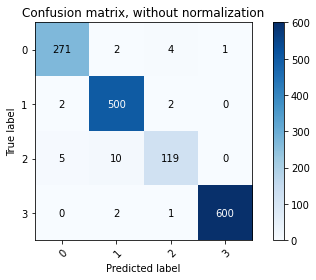

In [54]:
#Confusion Matrix
cm = confusion_matrix(labels_test, y_pred, labels=None, sample_weight=None)
print(cm)
plot_confusion_matrix(labels_test, y_pred, classes=np.array(["0","1","2","3"]), normalize=False)

<H1>Blind Test</H1>

In [55]:
#Importing blind set (no duplicates)
path = "/content/drive/MyDrive/Machine Learning/HW1/blindtest.json"
blind_f = open(path, 'r', encoding='utf-8')

#Take features
blind_data = take_features(blind_f, 'blind')
blind_f.close() 

predictions = forest.predict(blind_data)

#Open file to fill with my results
blind_results = open("/content/drive/My Drive/Machine Learning/HW1/1814407.txt", 'w', encoding='utf-8')
for p in predictions:
  res = ''
  if p==0:
    res = 'encryption\n'
  elif p==1:
    res = 'string\n'
  elif p==2:
    res = 'sort\n'
  else:
    res = 'math\n'
  blind_results.write(res)

blind_results.close()

Length of data: 757
